In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
from scipy.integrate import odeint
from numpy.linalg import inv
import pdb
import scipy.io
from scipy.stats.distributions import chi2

In [2]:
data_file = scipy.io.loadmat('../DATA/cooplocalization_finalproj_KFdata.mat')
data_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr  9 16:24:23 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Qtrue': array([[0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.01 , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.01 ]]),
 'Rtrue': array([[2.25e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 6.40e+01, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 4.00e-02, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 3.60e+01, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 3.60e+01]]),
 'measLabels': array([[array(['\\gamma_{ag} (rads)'], dtype='<U18'),
         array(['\\rho_{ga} (m)'], dtype='<U13'),
         array(['\\gamma_{ga} (rads)'], dtype='<U18'),
         array(['\\xi_a (m)'], dtype='<U9'),
        

In [33]:
#Initializations

x0 = np.array([10,0,np.pi/2,-60,0,-np.pi/2]).reshape(6,1)
u = np.array([2, -np.pi/18, 12, np.pi/25])
L = 0.5
delta_t = 0.1
time_steps = data_file['tvec'].transpose()
time_steps = time_steps.reshape(len(time_steps),)
#time_steps = np.linspace(0,500,5000)
Qtrue = data_file['Qtrue']
cholesky_decomposition_Qtrue = np.linalg.cholesky(Qtrue)
Rtrue = data_file['Rtrue']
cholesky_decomposition_Rtrue = np.linalg.cholesky(Rtrue)
plt.rcParams["figure.figsize"] = (15,15)

Y_from_file = []
given_y_data = data_file['ydata'].transpose()
for i in range(0,len(given_y_data)):
    Y_from_file.append(given_y_data[i].reshape(len(Rtrue),1))

In [40]:
#Generate True data with noise

def model(x, t, u, noise, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g) + noise[0][0]
    dxdt[1] = v_g*np.sin(theta_g) + noise[1][0]
    dxdt[2] = (v_g/L)*np.tan(phi_g) + noise[2][0]
    dxdt[3] = v_a*np.cos(theta_a) + noise[3][0]
    dxdt[4] = v_a*np.sin(theta_a) + noise[4][0]
    dxdt[5] = w_a + noise[5][0]
    return dxdt

def calculate_exact_yt(x,v):
    temptop = (x[4]-x[1])
    tempbot = (x[3]-x[0])
    y1 = np.arctan2(temptop,tempbot) - (x[2])
    if y1 < 0:
        y1 = y1 + 2*np.pi
    y1 = y1 - np.pi
    y2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    y3 = np.arctan2(-temptop,-tempbot) - (x[5])
    if y3 < 0:
        y3 = y3 + 2*np.pi
    y4 = x[3]
    y5 = x[4]
    
    yt = np.array([
                [y1],
                [y2],
                [y3],
                [y4],
                [y5]
                ])
    yt = yt + v
    return yt

def wrap_in_negative_pi_to_pi(theta):
    wrapped_angle = (theta + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

In [41]:
#Jacobians

def get_CT_Jacobians(x,u,time_update_flag,measurement_update_flag):
    
    A = 0; B = 0; Ga = 0; C = 0; D = 0
    
    if(time_update_flag):    
        A = np.array([
                [0, 0, -u[0]*np.sin(x[2]), 0, 0, 0],
                [0, 0, u[0]*np.cos(x[2]), 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, -u[2]*np.sin(x[5])],
                [0, 0, 0, 0, 0, u[2]*np.cos(x[5])],
                [0, 0, 0, 0, 0, 0]])

        Ga = np.eye(6)
    
    if(measurement_update_flag):
    
        denominator_1 = 1 + ((x[4]-x[1])/(x[3]-x[0]))**2
        numerator_11 = (x[4]-x[1]) / ((x[3] - x[0])**2)
        C11 = numerator_11/denominator_1

        numerator_12 = -1/(x[3]-x[0])
        C12 = numerator_12/denominator_1

        C14 = -1*C11
        C15 = -1*C12

        denominator_2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
        C21 = (x[0]-x[3])/denominator_2
        C22 = (x[1]-x[4])/denominator_2
        C24 = -1*C21
        C25 = -1*C22

        C = np.array([
                [C11, C12, -1, C14, C15, 0],
                [C21, C22, 0, C24, C25, 0],
                [C11, C12, 0, C14, C15, -1],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0]
                ])
    
    return A,B, Ga, C, D

def get_DT_Jacobians(x,u,dt,time_update_flag,measurement_update_flag):
    
    A,B,Gamma,C,D = get_CT_Jacobians(x,u,time_update_flag,measurement_update_flag)
    F = 0; G = 0; Omega = 0; H = 0; M = 0
    if(time_update_flag):
        F = np.eye(6) + dt*A
        Omega = delta_t*Gamma
    if(measurement_update_flag):
        H = C
        M = D
    
    return F,G,Omega,H,M

In [42]:
#Extended Kalman Filter

def kf_time_update(xk,Pk,uk,Q):
    n = len(xk)
    noise = np.zeros(n).reshape(n,1)
    #Calculate Jacobians    
    Fk,Gk,Omegak,Hk,Mk = get_DT_Jacobians(xk.reshape(n,),uk,delta_t,True,False)
    #Calculate x(k+1) minus
    #Note x(k+1) minus is of shape (n,) (just one dimension)
    xk_propogated = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,noise,L))
    xk_propogated = xk_propogated[-1]
    xk_propogated[2] = wrap_in_negative_pi_to_pi(xk_propogated[2])
    xk_propogated[5] = wrap_in_negative_pi_to_pi(xk_propogated[5]) 
    #Calculate P(k+1) minus
    Pk_propogated = np.dot(Fk,np.dot(Pk,Fk.transpose())) + np.dot(Omegak,np.dot(Q,Omegak.transpose()))
    
    return xk_propogated, Pk_propogated

def kf_measurement_update(xk_propogated,Pk_propogated,yk_observed,uk,R):
    #noise
    p = len(yk_observed)
    v = np.zeros(p).reshape(p,1)
    yk_predicted = calculate_exact_yt(xk_propogated,v)
    surprise_factor = yk_observed - yk_predicted
    surprise_factor[0][0] = wrap_in_negative_pi_to_pi(surprise_factor[0][0])
    surprise_factor[2][0] = wrap_in_negative_pi_to_pi(surprise_factor[2][0])
    #Calculate Jacobians
    Fk_plus1_minus,Gk_plus1_minus,Omegak_plus1_minus,Hk_plus1_minus,Mk_plus1_minus = get_DT_Jacobians(xk_propogated,uk,delta_t,False,True)
    #Calculate Kalman Gain
    fc_kalman_gain = np.dot(Pk_propogated,Hk_plus1_minus.transpose())
    sc_kalman_gain = np.dot(Hk_plus1_minus,np.dot(Pk_propogated,Hk_plus1_minus.transpose())) + R
    kalman_gain = np.dot(fc_kalman_gain,inv(sc_kalman_gain))
    #Calculate x(k+1) plus
    n = len(xk_propogated)
    xk_plus1 = xk_propogated.reshape(n,1) + np.dot(kalman_gain,surprise_factor)
    xk_plus1[2][0] = wrap_in_negative_pi_to_pi(xk_plus1[2][0])
    xk_plus1[5][0] = wrap_in_negative_pi_to_pi(xk_plus1[5][0]) 
    #Calculate P(k+1) plus
    I = np.identity(n)
    fc_Pk_plus1 = I - np.dot(kalman_gain,Hk_plus1_minus)
    Pk_plus1 = np.dot(fc_Pk_plus1, Pk_propogated)
    
    return xk_plus1,Pk_plus1,sc_kalman_gain

def get_estimated_states_and_measurements(x0,P0,u,observed_measurements_list,Q,R):
    xk = x0
    Pk = P0
    estimated_state_list = [xk]
    estimated_covariance_matrix_list = [Pk]
    estimated_measurement_list = []
    innovation_covariance_matrix_list = []
    n = len(x0)
    p = len(observed_measurements_list[0])
    zero_measurement_noise = np.zeros(p).reshape(p,1)
    for observed_measurement in observed_measurements_list[1:]:
        xk_propogated,Pk_propogated = kf_time_update(xk,Pk,u,Q)
        xk_plus1,Pk_plus1,innovation_covariance_matrix = kf_measurement_update(xk_propogated,Pk_propogated,observed_measurement,u,R)
        estimated_measurement = calculate_exact_yt(xk_propogated,zero_measurement_noise)
        estimated_state_list.append(xk_plus1)
        estimated_covariance_matrix_list.append(Pk_plus1)
        estimated_measurement_list.append(estimated_measurement)
        innovation_covariance_matrix_list.append(innovation_covariance_matrix)
        xk = xk_plus1
        Pk = Pk_plus1

    return estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list
    

#estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Qtrue, u, Ytrue, Qtrue, Rtrue)

In [43]:
#Tuning EKF by changing Qfilter 

Q11 = 10
Q13 = 0
Q22 = 10
Q23 = 0
Q33 = 100
Q44 = 10
Q46 = 0
Q55 = 10
Q56 = 0
Q66 = 100

Qfilter = np.array([
        [Q11,    0.,    Q13   , 0.   , 0.   , 0.   ],
        [0. ,    Q22,   Q23   , 0.   , 0.   , 0.   ],
        [Q13,    Q23,   Q33   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , Q44    , 0.   , Q46   ],
        [0.   , 0.   , 0.   , 0.     , Q55  , Q56   ],
        [0.   , 0.   , 0.   , Q46    , Q56  , Q66 ]
    ])

Qfilter = 10*data_file['Qtrue']
Pstart = 100*data_file['Qtrue']

# Pstart = np.array([[10, 0.   , 0.   , 0.   , 0.   , 0.   ],
#        [0.   , 10, 0.   , 0.   , 0.   , 0.   ],
#        [0.   , 0.   , 10 , 0.   , 0.   , 0.   ],
#        [0.   , 0.   , 0.   , 10, 0.   , 0.   ],
#        [0.   , 0.   , 0.   , 0.   , 10, 0.   ],
#        [0.   , 0.   , 0.   , 0.   , 0.   , 10 ]])

In [44]:
estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Pstart, u, Y_from_file, Qfilter, Rtrue)
skip_till = 0

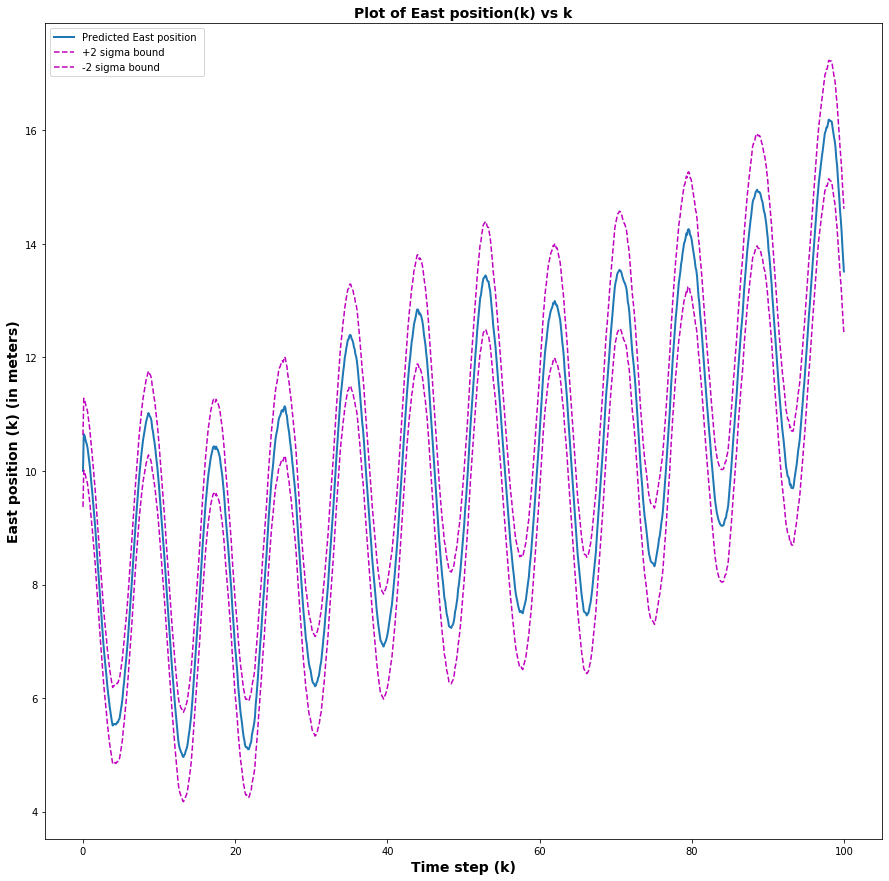

In [45]:
#Plot of East Position of UGV
state_element1_list = []
positive_two_sigma_state_element1_list = []
negative_two_sigma_state_element1_list = []

for i in range(0,len(estimated_state_list)):
    curr_element_mean = estimated_state_list[i][0][0]
    curr_variance = estimated_covariance_matrix_list[i][0][0]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    state_element1_list.append(curr_element_mean)
    positive_two_sigma_state_element1_list.append(curr_element_mean+bound)
    negative_two_sigma_state_element1_list.append(curr_element_mean-bound)
        
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("East position (k) (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of East position(k) vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps,state_element1_list,linewidth = 2,label = 'Predicted East position ')
plt.plot(time_steps,positive_two_sigma_state_element1_list,'--m',label = '+2 sigma bound')
plt.plot(time_steps,negative_two_sigma_state_element1_list,'--m',label = '-2 sigma bound')
plt.rcParams["figure.figsize"] = (15,15)
plt.legend()

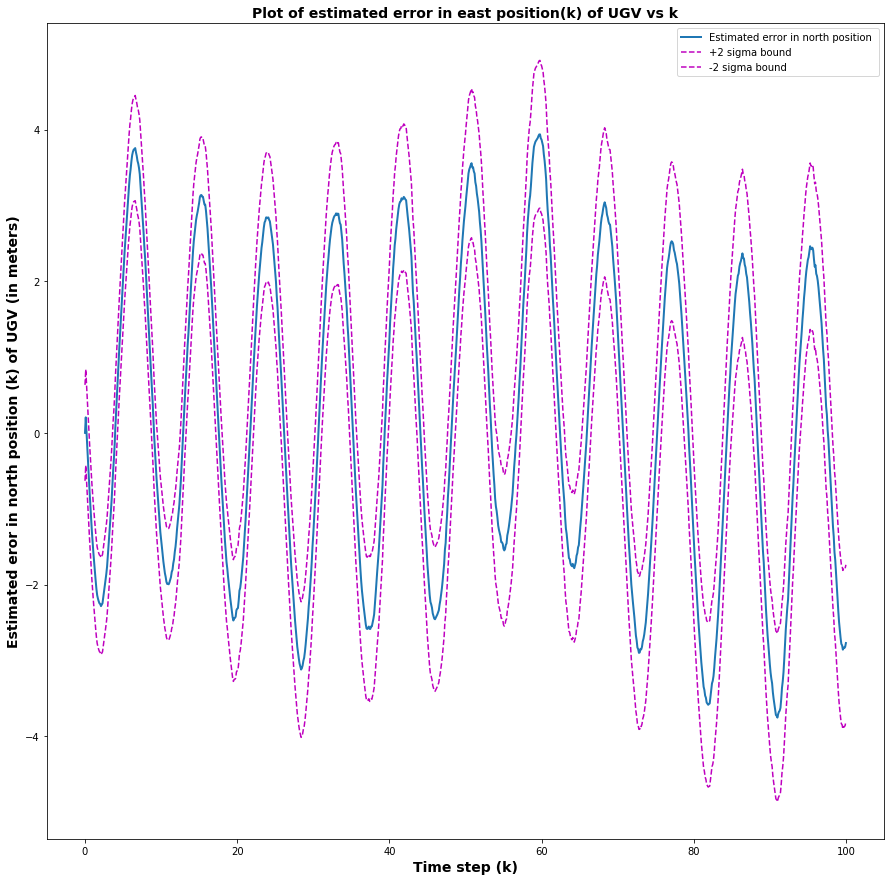

In [46]:
#Plot of North Position of UGV
state_element2_list = []
positive_two_sigma_state_element2_list = []
negative_two_sigma_state_element2_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_state_list[i][1][0]
    curr_variance = estimated_covariance_matrix_list[i][1][1]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    state_element2_list.append(curr_estimate)
    positive_two_sigma_state_element2_list.append(curr_estimate+bound)
    negative_two_sigma_state_element2_list.append(curr_estimate-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in north position (k) of UGV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],state_element2_list[skip_till:],linewidth = 2,label = 'Estimated error in north position ')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element2_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element2_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

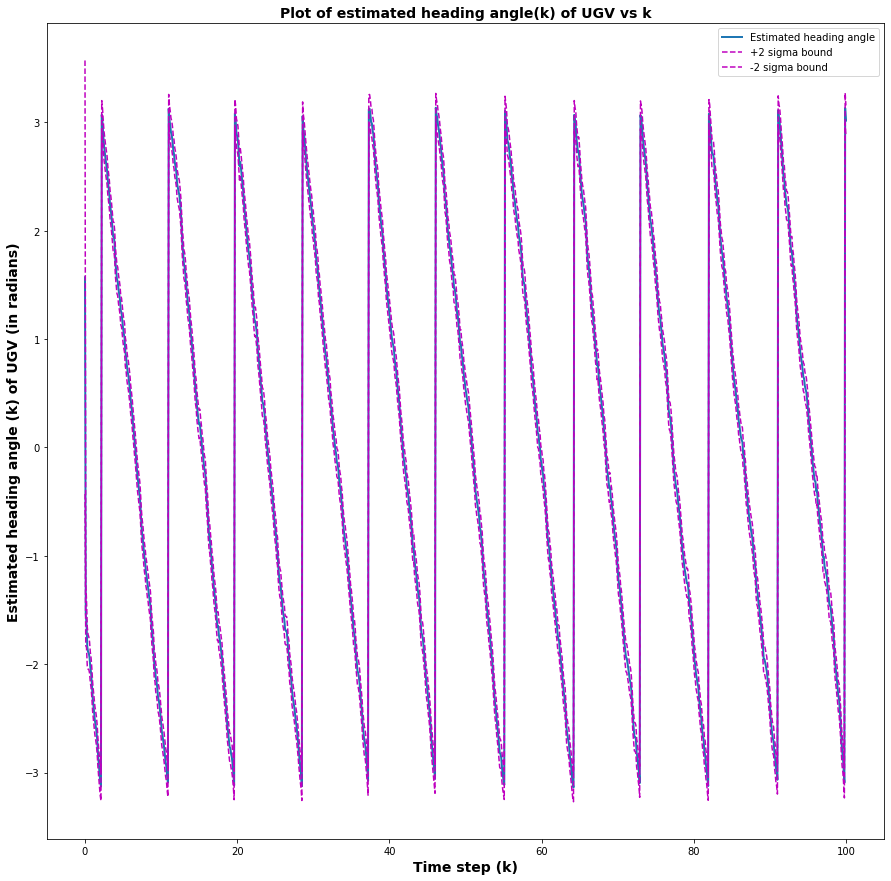

In [47]:
#Plot of heading angle of UGV
state_element3_list = []
positive_two_sigma_state_element3_list = []
negative_two_sigma_state_element3_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_state_list[i][2][0]
    curr_variance = estimated_covariance_matrix_list[i][2][2]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    state_element3_list.append(curr_estimate)
    positive_two_sigma_state_element3_list.append(curr_estimate+bound)
    negative_two_sigma_state_element3_list.append(curr_estimate-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated heading angle (k) of UGV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated heading angle(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],state_element3_list[skip_till:],linewidth = 2,label = 'Estimated heading angle')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element3_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element3_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

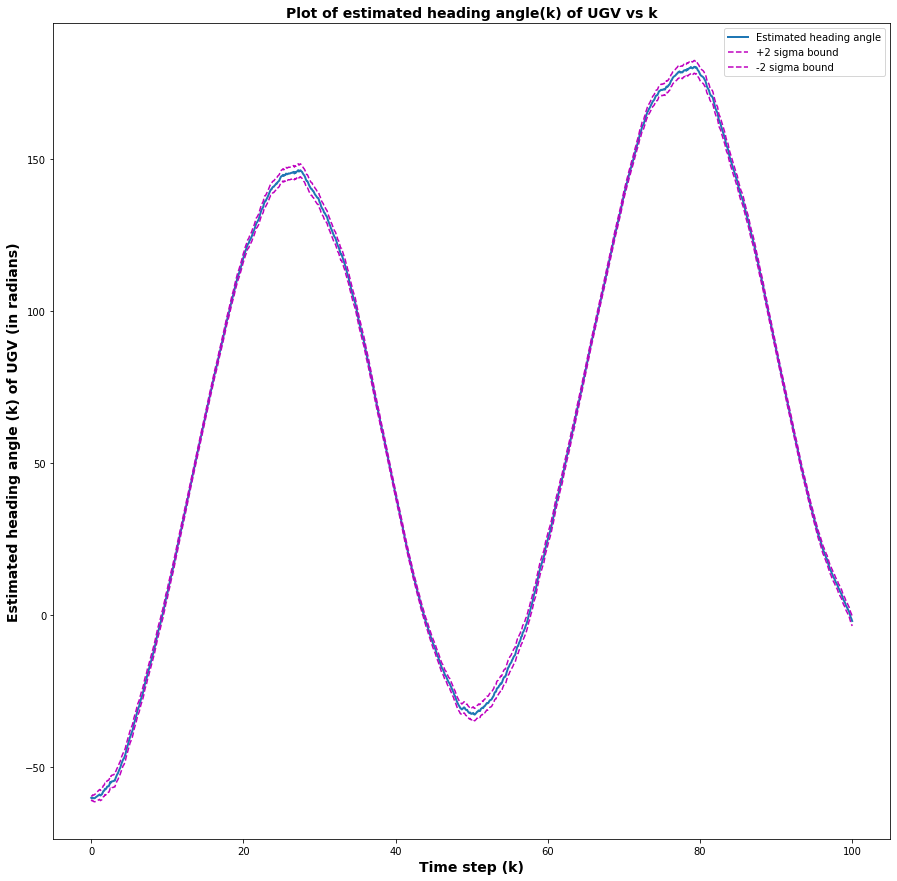

In [48]:
#Plot of heading angle of UGV
state_element4_list = []
positive_two_sigma_state_element4_list = []
negative_two_sigma_state_element4_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_state_list[i][3][0]
    curr_variance = estimated_covariance_matrix_list[i][3][3]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    state_element4_list.append(curr_estimate)
    positive_two_sigma_state_element4_list.append(curr_estimate+bound)
    negative_two_sigma_state_element4_list.append(curr_estimate-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated heading angle (k) of UGV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated heading angle(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],state_element4_list[skip_till:],linewidth = 2,label = 'Estimated heading angle')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element4_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element4_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

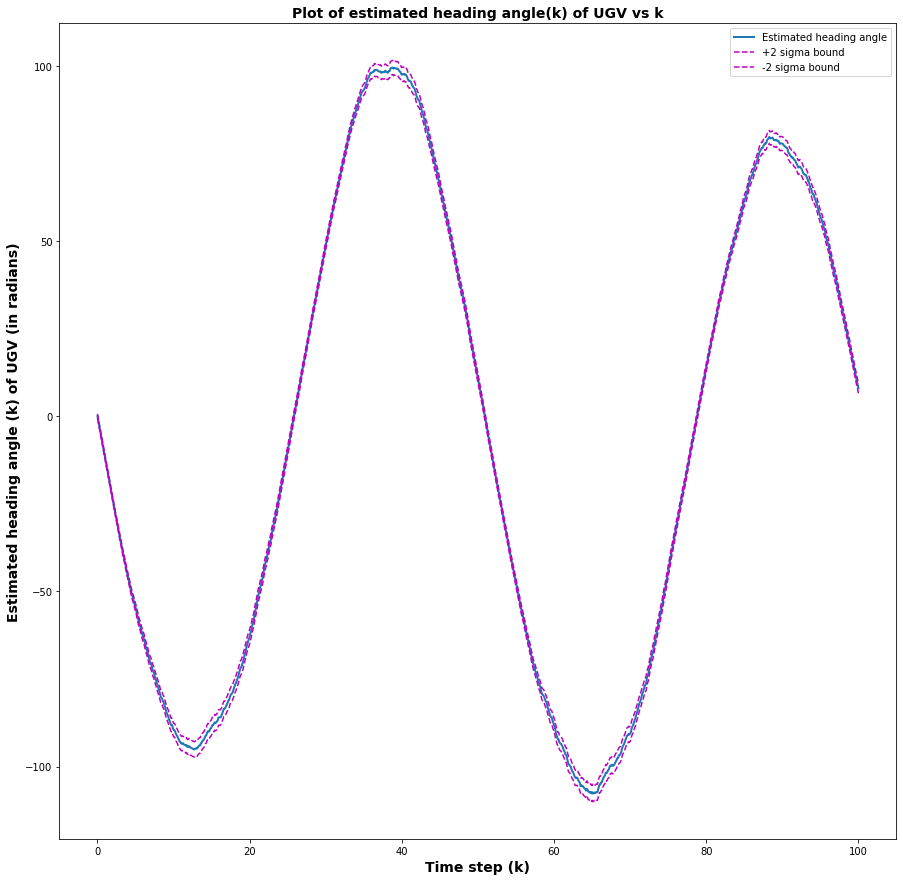

In [52]:
#Plot of heading angle of UGV
state_element5_list = []
positive_two_sigma_state_element5_list = []
negative_two_sigma_state_element5_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_state_list[i][4][0]
    curr_variance = estimated_covariance_matrix_list[i][4][4]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    state_element5_list.append(curr_estimate)
    positive_two_sigma_state_element5_list.append(curr_estimate+bound)
    negative_two_sigma_state_element5_list.append(curr_estimate-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated heading angle (k) of UGV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated heading angle(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],state_element5_list[skip_till:],linewidth = 2,label = 'Estimated heading angle')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element5_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element5_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

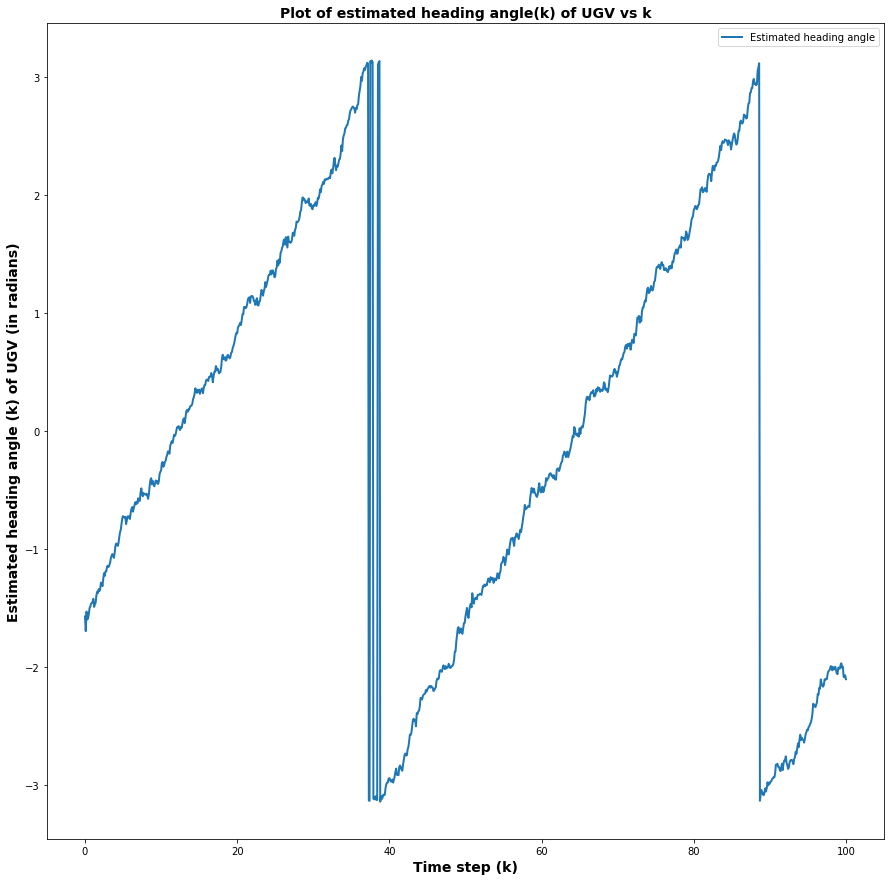

In [56]:
#Plot of heading angle of UGV
state_element6_list = []
positive_two_sigma_state_element6_list = []
negative_two_sigma_state_element6_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_state_list[i][5][0]
    curr_estimate = wrap_in_negative_pi_to_pi(curr_estimate)
    curr_variance = estimated_covariance_matrix_list[i][5][5]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    state_element6_list.append(curr_estimate)
    positive_two_sigma_state_element6_list.append(curr_estimate+bound)
    negative_two_sigma_state_element6_list.append(curr_estimate-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated heading angle (k) of UGV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated heading angle(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],state_element6_list[skip_till:],linewidth = 2,label = 'Estimated heading angle')
# plt.plot(time_steps[skip_till:],positive_two_sigma_state_element6_list[skip_till:],'--m',label = '+2 sigma bound')
# plt.plot(time_steps[skip_till:],negative_two_sigma_state_element6_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()